# Sentence-level analysis on a single book: 

In [1]:
import nltk
import re
import pandas as pd

import numpy as np
from scipy.stats import mode
from scipy import spatial

import sklearn.feature_extraction.text as text
from sklearn import decomposition

import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
from nltk.tokenize import sent_tokenize
from nltk.tokenize import wordpunct_tokenize

import pickle

In [2]:
#unpickle

pickloader = open( "books_df.pkl","rb")
books_df = pickle.load(pickloader)
pickloader.close()

pickloader=open( "lemmed_books.pkl", "rb" )
clean_books = pickle.load(pickloader)
pickloader.close()

pickloader=open("book_titles.pkl","rb")
titles = pickle.load(pickloader)
pickloader.close()

pickloader=open("book_authors.pkl","rb")
authors = pickle.load(pickloader)
pickloader.close()

pickloader=open("book_clusters.pkl","rb")
book_clusters = pickle.load(pickloader)
pickloader.close()

pickloader=open("clean_book_sentences.pkl","rb")
clean_book_sentences = pickle.load(pickloader)
pickloader.close()

pickloader=open("vocab.pkl","rb")
vocab = pickle.load(pickloader)
pickloader.close()

pickloader=open("dtm.pkl","rb")
dtm = pickle.load(pickloader)
pickloader.close()

pickloader=open("doctopic.pkl","rb")
doctopic = pickle.load(pickloader)
pickloader.close()

pickloader=open("topics.pkl","rb")
topics = pickle.load(pickloader)
pickloader.close()

In [46]:
clean_books[5][:1000]

"the time machine , by h . g . well [ 1898 ] i the time traveller ( for so it will be convenient to speak of him ) wa expounding a recondite matter to u . his grey eye shone and twinkled , and his usually pale face wa flushed and animated . the fire burned brightly , and the soft radiance of the incandescent light in the lily of silver caught the bubble that flashed and passed in our glass . our chair , being his patent , embraced and caressed u rather than submitted to be sat upon , and there wa that luxurious after - dinner atmosphere when thought roams gracefully free of the trammel of precision . and he put it to u in this way -- marking the point with a lean forefinger -- a we sat and lazily admired his earnestness over this new paradox ( a we thought it ) and his fecundity . ' you must follow me carefully . i shall have to controvert one or two idea that are almost universally accepted . the geometry , for instance , they taught you at school is founded on a misconception .' ' is

In [26]:
clean_books = [book.lower() for book in clean_books]

In [12]:
# Lemming: a gentler approach: 
lemma=nltk.stem.WordNetLemmatizer()

lemma_books = []
for book in clean_books:
    lemma_book = [lemma.lemmatize(word) for word in wordpunct_tokenize(book)]
    lemma_book = (' ').join(lemma_book)
    lemma_books.append(lemma_book)

lemma_books[0][0:100]

clean_books = lemma_books

In [27]:
#I want to use the expanded and lemmatized tokens of sentences

clean_book_sentences = []
for book in clean_books:
    sentences = sent_tokenize(book)
    clean_book_sentences.append(sentences)

In [1]:
pickler = open("clean_book_sentences.pkl","wb")
pickle.dump(clean_book_sentences, pickler)
pickler.close()

NameError: name 'pickle' is not defined

### Function for creating an average sentiment polarity for each bin:

In [38]:
clean_book_sentences[0][2]

"down the rabbit - hole alice wa beginning to get very tired of sitting by her sister on the bank , and of having nothing to do : once or twice she had peeped into the book her sister wa reading , but it had no picture or conversation in it , ' and what is the use of a book ,' thought alice ' without picture or conversation ?'"

In [42]:
sentiments = [TextBlob(sentence).sentiment.polarity for sentence in clean_book_sentences[novel_index]]
sentiments[:5] #etc

[0.11562499999999999, -0.13472222222222222, 0.3, 0.0, 0.0]

In [21]:
#you might want to play with this depending on article/book/text format
number_of_buckets = 5 

#Novel has Exposition, Rising Action, Climax, Falling Action, Resolution, hence 5

def get_sentiment(novel_index):

    #make list of sentiment by sentences
    sentiments = [TextBlob(sentence).sentiment.polarity for sentence in clean_book_sentences[novel_index]]
    
    #bin list into buckets
    sentiments_binned = list(np.array_split(sentiments, 5))

    #take the mean of each bucket for graphing
    sentiments_binned = [np.mean(bin) for bin in sentiments_binned]
    
    return(sentiments_binned)

pandas.core.series.Series

In [57]:
# choosing the book:
novel_index=2400
print('Title:', titles[novel_index])

Title: Cry from a Far Planet


/Users/clarencestephen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  from ipykernel import kernelapp as app


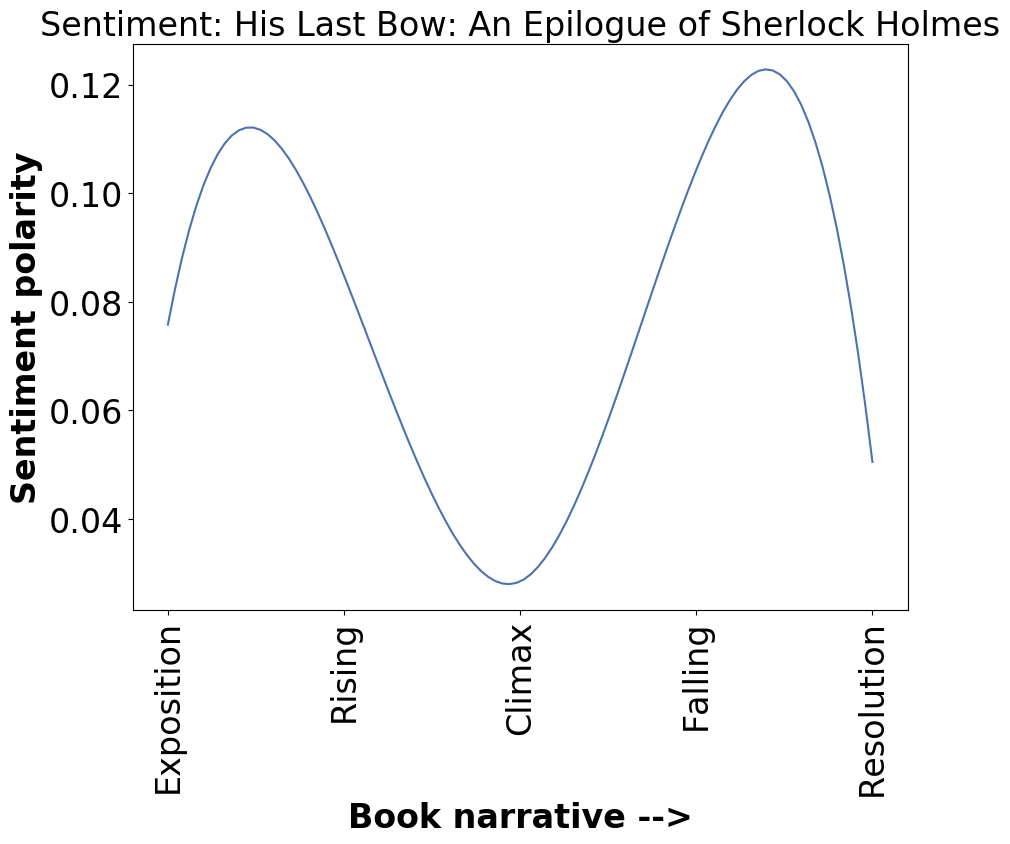

In [54]:
from scipy.interpolate import spline
sentiments_binned = get_sentiment(novel_index)

plot_names = ['Exposition', 'Rising', 'Climax', 'Falling', 'Resolution']
y_pos = np.arange(len(sentiments_binned))
plt.figure(figsize=(10,7.5))
# plt.plot(sentiments_binned) #height=sentiments_binned);
plt.ylabel("Sentiment polarity")
plt.xlabel("Book narrative -->")
plt.xticks(y_pos,plot_names, rotation=90)
plt.title(f'Sentiment: {titles[novel_index]}');

xnew = np.linspace(y_pos.min(),y_pos.max(),100) #300 represents number of points to make between T.min and T.max

power_smooth = spline(y_pos,sentiments_binned,xnew)

plt.plot(xnew,power_smooth)
plt.show()

In [30]:
def stack_arrays(your_function, n_iterations):
    for i in range(n_iterations):
        if i == 0:
            array = your_function(i)
        else:
            next_array = your_function(i)
            array = np.vstack((array,next_array))
    return array

In [93]:
sentiment_array = stack_arrays(get_sentiment,len(titles))
print(sentiment_array[:-4])

[[ 0.02781264  0.02155577 -0.00796654  0.03514108  0.05815842]
 [ 0.0620693   0.06726999  0.05407732  0.06650897  0.04106672]
 [ 0.05331335  0.10981875  0.01448591  0.08518078  0.00223525]
 ...
 [ 0.01922992  0.0278562   0.04057638  0.02093143  0.04925693]
 [ 0.01311269  0.00975976  0.0290176   0.01354464  0.02966184]
 [ 0.03620931  0.04229893  0.04003319  0.04583339  0.05627271]]


In [94]:
column_names = ['exposition','rising action', 'climax', 'falling action', 'resolution']
sentiment_df = pd.DataFrame(sentiment_array, columns =[column_names])

In [95]:
sentiment_df['titles']=pd.Series(titles)

In [154]:
pickler = open("sentiment_array.pkl","wb")
pickle.dump(sentiment_array, pickler)
pickler.close()

pickler = open("sentiment_df.pkl","wb")
pickle.dump(sentiment_df, pickler)
pickler.close()

In [57]:
pickloader = open( "sentiment_array.pkl","rb")
sentiment_array = pickle.load(pickloader)
pickloader.close()

pickloader = open( "sentiment_df.pkl","rb")
sentiment_df = pickle.load(pickloader)
pickloader.close()

### TSNE on sentiment array

In [39]:
sentiment_df.head()

,exposition,rising action,climax,falling action,resolution,titles
0,0.027813,0.021556,-0.007967,0.035141,0.058158,Alice's Adventures in Wonderland
1,0.062069,0.067270,0.054077,0.066509,0.041067,Through the Looking-Glass
2,0.053313,0.109819,0.014486,0.085181,0.002235,The Hunting of the Snark: An Agony in Eight Fits
3,0.055155,0.083941,0.022135,0.066772,0.036421,Moby Dick
4,0.087218,0.064291,0.181911,0.060598,0.075006,The Song of Hiawatha


In [58]:
from sklearn.manifold import TSNE
#cosine because we care about the trajectory of the plot, not the absolute polarity
tsne2 = TSNE(n_components=2, learning_rate=25.0, perplexity =30.0, n_iter = 1000, n_iter_without_progress = 100, random_state=42,metric='euclidean', angle =0.1) 
X_tsne2 = tsne2.fit_transform(sentiment_array)

KeyboardInterrupt: 

In [ ]:
X_tsne2.shape

In [ ]:
X_tsne2.T.shape

In [ ]:
#get sentiment clusters
from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=10, random_state = 42)
clusters = clustering.fit_predict(sentiment_array)
clusters.shape

In [43]:
book_clusters = pd.DataFrame()
book_clusters['titles'] = titles
book_clusters['cluster'] = clusters
book_clusters.head()

,titles,cluster
0,Alice's Adventures in Wonderland,3
1,Through the Looking-Glass,4
2,The Hunting of the Snark: An Agony in Eight Fits,4
3,Moby Dick,4
4,The Song of Hiawatha,6


In [ ]:
# plot data
data = pd.DataFrame()
data['x']=X_tsne2.T[0]
data['y']=X_tsne2.T[1]
data['labels']=list(clusters)

median_cluster_location = data.groupby(['labels']).median().reset_index()
median_cluster_location['x'] = median_cluster_location.x.astype(int)
median_cluster_location['y'] = median_cluster_location.y.astype(int)
median_cluster_location['labels'] = median_cluster_location.labels.astype(str)


def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(len(set(clusters)))
fig, ax = plt.subplots(figsize=(16, 16))

for cluster in set(clusters):
    plotdata=data[data['labels']==cluster]
    x, y = plotdata['x'], plotdata['y']
    ax.scatter(x, y, c=cmap(cluster), label=cluster, alpha=0.5, edgecolors='none')

# add annotations one by one with a loop    
for line in range(0, median_cluster_location.shape[0]):
    ax.text(median_cluster_location.x[line]+0.2, median_cluster_location.y[line], median_cluster_location.labels[line],
                   horizontalalignment='left', size='medium', color='black', weight='semibold')

ax.legend()
# ax.grid(True)

plt.show()

### Function to make the topic change graph:

In [3]:
def get_topic_deltas(novel_index):

    vectorizer = text.TfidfVectorizer()
    dtm = vectorizer.fit_transform(clean_book_sentences[novel_index]).toarray()
    
    num_topics = 20
    NMFmodel = decomposition.NMF(n_components=num_topics, random_state=42)
    doctopic = NMFmodel.fit_transform(dtm)
    vocab = np.array(vectorizer.get_feature_names())
    
    try:
        doctopic = doctopic / np.sum(doctopic, axis=1, keepdims=True)
    except:
        pass
    
    doctopic = np.nan_to_num(doctopic)
    
    # make a list of the topic words for each topic
    num_top_words = 20
    topic_words = []
    for topic in NMFmodel.components_:
        word_idx = np.argsort(topic)[::-1][0:num_top_words]
        topic_words.append([vocab[i] for i in word_idx])

    # cosine similarity between topics for the distance

    maxtopics = [list(sentence).index(max(sentence)) for sentence in doctopic]
    
    limit = 30
    
    if len(maxtopics)>limit:
        maxtopics_binned = list(np.array_split(maxtopics, limit))
    else:
        maxtopics_binned = list(np.array_split(maxtopics, len(maxtopics)))
        
    maxtopics_binned = [mode(topicbin).mode[0] if len(topicbin)>1 else topicbin[0] for topicbin in maxtopics_binned]

    topic_deltas = []
    for i in range(1, len(maxtopics_binned)):
        last_index = maxtopics_binned[i-1]
        current_index = maxtopics_binned[i]
        topic_distance = spatial.distance.cosine(
            NMFmodel.components_[last_index], NMFmodel.components_[current_index])
        topic_deltas.append(topic_distance)

    return(topic_deltas, topic_words)

In [ ]:
novel_index=3
topic_deltas, topic_words = get_topic_deltas(novel_index)
y_pos = np.arange(len(topic_deltas))
plt.figure(figsize=(15, 6))
plt.bar(y_pos, height=[delta-0.85 if delta>0 else 0 for delta in topic_deltas])
plt.ylabel("Topic change distance")
plt.xlabel("Book narrative -->")
plt.title(f'Topic change distance for {titles[novel_index]}');

print('Total "complexity":', sum([delta-0.85 if delta>0 else 0 for delta in topic_deltas]))

for t in range(len(topic_words)):
    print("Topic {}: {}".format(t, ' '.join(topic_words[t][:20])))

2.5901083021488023

### Pickling for the dash app:

### Make the book directories:

In [163]:
import os, sys

for i in range(len(clean_books)):
    os.mkdir('books/'+str(i));

### Save the relevant pickle files for each book to each directory:

In [171]:
# Double checking that they're the same length
print("Number of books:",len(clean_books))
print("Number of novel names:", len(titles))

Number of books: 3524
Number of novel names: 3524


### Pickling topics & sentiments

In [172]:
for i in range(len(clean_books)):
    sentiments_binned = list(sentiment_array[i])
    with open('books/'+str(i)+'/sentiments_binned'+'.pkl', 'wb') as f:
        pickle.dump(sentiments_binned, f)
        f.close()

In [6]:
errors = []

In [7]:
# restarting from the index it last completed
# 846 failed due to the number of bins being larger than the number of sentences (now fixed with conditional)
pickupnum=1360
#modify range if necessary
for i in range(len(clean_books)):
    print(f'trying {i}')
    try:
        topic_deltas, topic_words = get_topic_deltas(i)
        with open('books/'+str(i)+'/topic_deltas'+'.pkl', 'wb') as f:
            pickle.dump(topic_deltas, f)
            f.close()
    except:
        errors.append(str(i))
        


trying 0


/Users/clarencestephen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Users/clarencestephen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


trying 1
trying 2
trying 3
trying 4
trying 5
trying 6
trying 7
trying 8
trying 9
trying 10
trying 11
trying 12
trying 13
trying 14
trying 15
trying 16
trying 17
trying 18
trying 19
trying 20
trying 21
trying 22
trying 23
trying 24
trying 25
trying 26
trying 27
trying 28
trying 29
trying 30
trying 31
trying 32
trying 33
trying 34
trying 35
trying 36
trying 37
trying 38
trying 39
trying 40
trying 41
trying 42
trying 43
trying 44
trying 45
trying 46
trying 47
trying 48
trying 49
trying 50
trying 51
trying 52
trying 53
trying 54
trying 55
trying 56
trying 57
trying 58
trying 59
trying 60
trying 61
trying 62
trying 63
trying 64
trying 65
trying 66
trying 67
trying 68
trying 69
trying 70
trying 71
trying 72
trying 73
trying 74
trying 75
trying 76
trying 77
trying 78
trying 79
trying 80
trying 81
trying 82
trying 83
trying 84
trying 85
trying 86
trying 87
trying 88
trying 89
trying 90
trying 91
trying 92
trying 93
trying 94
trying 95
trying 96
trying 97
trying 98
trying 99
trying 100
trying 1

trying 756
trying 757
trying 758
trying 759
trying 760
trying 761
trying 762
trying 763
trying 764
trying 765
trying 766
trying 767
trying 768
trying 769
trying 770
trying 771
trying 772
trying 773
trying 774
trying 775
trying 776
trying 777
trying 778
trying 779
trying 780
trying 781
trying 782
trying 783
trying 784
trying 785
trying 786
trying 787
trying 788
trying 789
trying 790
trying 791
trying 792
trying 793
trying 794
trying 795
trying 796
trying 797
trying 798
trying 799
trying 800
trying 801
trying 802
trying 803
trying 804
trying 805
trying 806
trying 807
trying 808
trying 809
trying 810
trying 811
trying 812
trying 813
trying 814
trying 815
trying 816
trying 817
trying 818
trying 819
trying 820
trying 821
trying 822
trying 823
trying 824
trying 825
trying 826
trying 827
trying 828
trying 829
trying 830
trying 831
trying 832
trying 833
trying 834
trying 835
trying 836
trying 837
trying 838
trying 839
trying 840
trying 841
trying 842
trying 843
trying 844
trying 845
trying 846

trying 1460
trying 1461
trying 1462
trying 1463
trying 1464
trying 1465
trying 1466
trying 1467
trying 1468
trying 1469
trying 1470
trying 1471
trying 1472
trying 1473
trying 1474
trying 1475
trying 1476
trying 1477
trying 1478
trying 1479
trying 1480
trying 1481
trying 1482
trying 1483
trying 1484
trying 1485
trying 1486
trying 1487
trying 1488
trying 1489
trying 1490
trying 1491
trying 1492
trying 1493
trying 1494
trying 1495
trying 1496
trying 1497
trying 1498
trying 1499
trying 1500
trying 1501
trying 1502
trying 1503
trying 1504
trying 1505
trying 1506
trying 1507
trying 1508
trying 1509
trying 1510
trying 1511
trying 1512
trying 1513
trying 1514
trying 1515
trying 1516
trying 1517
trying 1518
trying 1519
trying 1520
trying 1521
trying 1522
trying 1523
trying 1524
trying 1525
trying 1526
trying 1527
trying 1528
trying 1529
trying 1530
trying 1531
trying 1532
trying 1533
trying 1534
trying 1535
trying 1536
trying 1537
trying 1538
trying 1539
trying 1540
trying 1541
trying 1542
tryi

trying 2143
trying 2144
trying 2145
trying 2146
trying 2147
trying 2148
trying 2149
trying 2150
trying 2151
trying 2152
trying 2153
trying 2154
trying 2155
trying 2156
trying 2157
trying 2158
trying 2159
trying 2160
trying 2161
trying 2162
trying 2163
trying 2164
trying 2165
trying 2166
trying 2167
trying 2168
trying 2169
trying 2170
trying 2171
trying 2172
trying 2173
trying 2174
trying 2175
trying 2176
trying 2177
trying 2178
trying 2179
trying 2180
trying 2181
trying 2182
trying 2183
trying 2184
trying 2185
trying 2186
trying 2187
trying 2188
trying 2189
trying 2190
trying 2191
trying 2192
trying 2193
trying 2194
trying 2195
trying 2196
trying 2197
trying 2198
trying 2199
trying 2200
trying 2201
trying 2202
trying 2203
trying 2204
trying 2205
trying 2206
trying 2207
trying 2208
trying 2209
trying 2210
trying 2211
trying 2212
trying 2213
trying 2214
trying 2215
trying 2216
trying 2217
trying 2218
trying 2219
trying 2220
trying 2221
trying 2222
trying 2223
trying 2224
trying 2225
tryi

trying 2826
trying 2827
trying 2828
trying 2829
trying 2830
trying 2831
trying 2832
trying 2833
trying 2834
trying 2835
trying 2836
trying 2837
trying 2838
trying 2839
trying 2840
trying 2841
trying 2842
trying 2843
trying 2844
trying 2845
trying 2846
trying 2847
trying 2848
trying 2849
trying 2850
trying 2851
trying 2852
trying 2853
trying 2854
trying 2855
trying 2856
trying 2857
trying 2858
trying 2859
trying 2860
trying 2861
trying 2862
trying 2863
trying 2864
trying 2865
trying 2866
trying 2867
trying 2868
trying 2869
trying 2870
trying 2871
trying 2872
trying 2873
trying 2874
trying 2875
trying 2876
trying 2877
trying 2878
trying 2879
trying 2880
trying 2881
trying 2882
trying 2883
trying 2884
trying 2885
trying 2886
trying 2887
trying 2888
trying 2889
trying 2890
trying 2891
trying 2892
trying 2893
trying 2894
trying 2895
trying 2896
trying 2897
trying 2898
trying 2899
trying 2900
trying 2901
trying 2902
trying 2903
trying 2904
trying 2905
trying 2906
trying 2907
trying 2908
tryi

trying 3509
trying 3510
trying 3511
trying 3512
trying 3513
trying 3514
trying 3515
trying 3516
trying 3517
trying 3518
trying 3519
trying 3520
trying 3521
trying 3522
trying 3523


In [ ]:
complexity = sum([delta-0.85 if delta>0 else 0 for delta in topic_deltas])
complexity

In [89]:
pickloader = open('books/'+str(1)+'/topic_deltas'+'.pkl', 'rb')
topic_deltas = pickle.load(pickloader)
pickloader.close()

In [93]:
for i in range(len(titles)):
    print(i)
    pickloader = open('books/'+str(i)+'/topic_deltas'+'.pkl', 'rb')
    topic_deltas = pickle.load(pickloader)
    pickloader.close()
    
    complexity = sum([delta-0.85 if delta>0 else 0 for delta in topic_deltas])


    with open('books/'+str(i)+'/complexity'+'.pkl', 'wb') as f:
            pickle.dump(complexity, f)
            f.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197


In [83]:
len(titles)

3524

In [8]:
import os
os.system("say 'done'")

0

In [90]:
errors = [0]

In [91]:
new_errors = []
for index in errors:
    print(f'trying {index}')
    try:
        topic_deltas, topic_words = get_topic_deltas(int(index)+1) #crude error management for continuity
        with open('books/'+str(index)+'/topic_deltas'+'.pkl', 'wb') as f:
            pickle.dump(topic_deltas, f)
            f.close()
    except:
        new_errors.append(str(index))

trying 0


/Users/clarencestephen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Users/clarencestephen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [92]:
new_errors

[]

In [321]:
avg_sentiment = []
for i in range (sentiment_array.shape[1]):
    avg_sentiment.append(sentiment_array[:,i].mean())

In [19]:
# loading example:

i=17

pickloader = open('books/'+str(i)+'/sentiments_binned'+'.pkl', 'rb')
sentiments_binned = pickle.load(pickloader)
pickloader.close()

pickloader = open('books/'+str(i)+'/topic_deltas'+'.pkl', 'rb')
topic_deltas = pickle.load(pickloader)
pickloader.close()

print(sentiments_binned)
print(topic_deltas)

[0.125, 0.0, -0.1517857142857143, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.9127510941372249, 0.9624185741094483, 0.9522230297811188, 0.0, 0.9116970912068543, 0.9376969990193503, 0.9613494925651234, 0.9803801451052073, 0.0, 0.9116970912068543, 0.9116970912068543, 0.0, 0.0, 0.9116970912068543, 0.9376969990193503, 0.903598548474595, 0.0, 0.9522230297811188, 0.9697599210841903, 0.9563672238613523, 0.0, 0.0, 0.9522230297811188, 0.0]


### Checking examples:

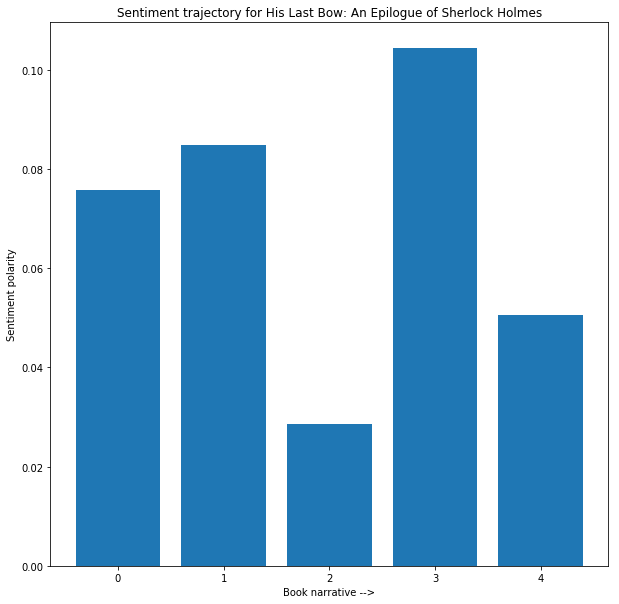

In [22]:
novel_index=321
sentiments_binned = get_sentiment(novel_index)
y_pos = np.arange(len(sentiments_binned))
plt.figure(figsize=(10,10))
plt.bar(y_pos, height=sentiments_binned);
plt.ylabel("Sentiment polarity")
plt.xlabel("Book narrative -->")
plt.title(f'Sentiment trajectory for {titles[novel_index]}');

Total "complexity": 2.5901083021488023


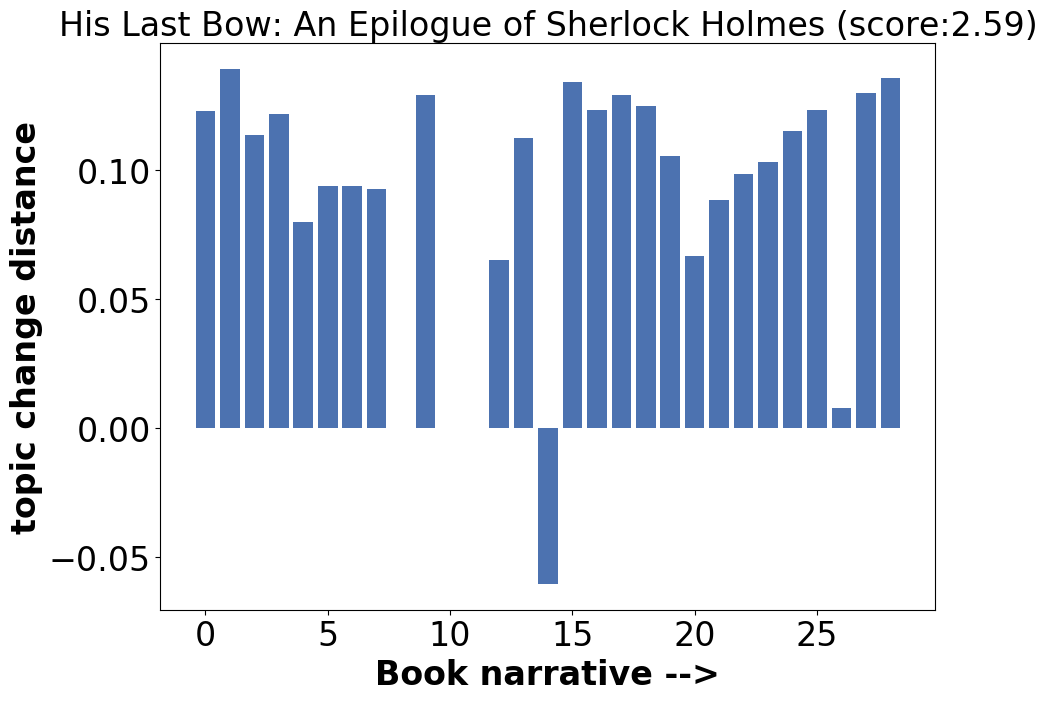

In [70]:
topic_deltas, topic_words = get_topic_deltas(novel_index);
y_pos = np.arange(len(topic_deltas))
plt.figure(figsize=(10, 7.5))
plt.bar(y_pos, height=[delta-0.85 if delta>0 else 0 for delta in topic_deltas])
complexity = sum([delta-0.85 if delta>0 else 0 for delta in topic_deltas])
plt.ylabel("topic change distance")
plt.xlabel("Book narrative -->")
plt.title(titles[novel_index]+' (score:'+str(round(complexity,3))+')')

print('Total "complexity":', sum([delta-0.85 if delta>0 else 0 for delta in topic_deltas]))

# subtract 0.85 to keep scale reasonable. Do not want tall topic change bars. Topic change isn't abnormal.

### Plotting the topics over the course of the novel:

In [25]:
# using bins of 50-ish sentences to see if that's better or worse than 100-ish sentence bins
doctopic_binned = list(np.array_split(doctopic, len(doctopic)//10))

In [26]:
np.nan_to_num(doctopic_binned[0]).mean(axis=0)

array([1.11432845e-01, 2.73582621e-02, 9.94493025e-02, 1.38530347e-02,
       3.70444431e-02, 9.70573056e-07, 7.05643799e-02, 6.80117623e-02,
       5.69747087e-02, 2.37444453e-01, 2.31904095e-02, 1.31973411e-01,
       5.53982316e-03, 3.83695468e-02, 7.87926475e-02])

In [35]:
binvals=[]

for sentbin in doctopic_binned:
    sentbin = np.nan_to_num(sentbin)
    print((sentbin.mean(axis=0)))
    print((sentbin.mean(axis=0)).sum())
    binvals.append(sentbin.mean(axis=0))

binvals = np.array(binvals)

[1.11432845e-01 2.73582621e-02 9.94493025e-02 1.38530347e-02
 3.70444431e-02 9.70573056e-07 7.05643799e-02 6.80117623e-02
 5.69747087e-02 2.37444453e-01 2.31904095e-02 1.31973411e-01
 5.53982316e-03 3.83695468e-02 7.87926475e-02]
1.0
[0.13125883 0.01552432 0.06297902 0.00581341 0.06785643 0.00359271
 0.09739412 0.0202511  0.08814235 0.21294137 0.07353479 0.07955291
 0.04706013 0.00576794 0.08833057]
0.9999999999999999
[0.18604819 0.09092783 0.01921057 0.         0.0716036  0.00257749
 0.05726734 0.05319246 0.09043098 0.26840269 0.07351417 0.01623884
 0.02627662 0.00279981 0.04150942]
1.0
[0.14976512 0.01023174 0.26271208 0.00427146 0.08496953 0.00432035
 0.05104084 0.0528581  0.00635971 0.22744671 0.0352357  0.07672297
 0.01389598 0.00981151 0.0103582 ]
1.0
[0.15509152 0.10784395 0.12955955 0.00320512 0.06810763 0.0125012
 0.05534966 0.07850345 0.02749648 0.16970588 0.02975795 0.12762196
 0.01317177 0.00023793 0.02184596]
1.0
[0.14725988 0.1206519  0.11506474 0.00943668 0.08354413 0.00

 0.03465324 0.04226882 0.02253251]
1.0
[0.05330414 0.00596816 0.03432593 0.00765514 0.09184631 0.00716
 0.34411737 0.05402527 0.00605595 0.0453295  0.17685257 0.12236628
 0.01110049 0.01112308 0.02876981]
0.9999999999999999
[0.01392281 0.00148548 0.10070771 0.01427017 0.00372106 0.00352861
 0.40979995 0.06744686 0.00670148 0.10122887 0.04927287 0.17332962
 0.01042426 0.0294923  0.01466794]
0.9999999999999998
[0.01412063 0.00063523 0.06730792 0.00864953 0.077382   0.01606478
 0.33656516 0.05067342 0.0094417  0.02431359 0.07952486 0.13808111
 0.10026707 0.03942095 0.03755206]
1.0000000000000002
[0.05917729 0.00118735 0.09397998 0.01573103 0.04381118 0.00238645
 0.28105393 0.07272812 0.01513221 0.06769079 0.0921408  0.21715618
 0.01716848 0.00731596 0.01334023]
1.0
[0.05945037 0.02183677 0.1366275  0.01590692 0.01928927 0.00731021
 0.3633912  0.03121521 0.00374305 0.06155175 0.08469675 0.08507283
 0.03861546 0.04922028 0.02207243]
1.0
[0.03862909 0.01684902 0.091838   0.00396663 0.0404049

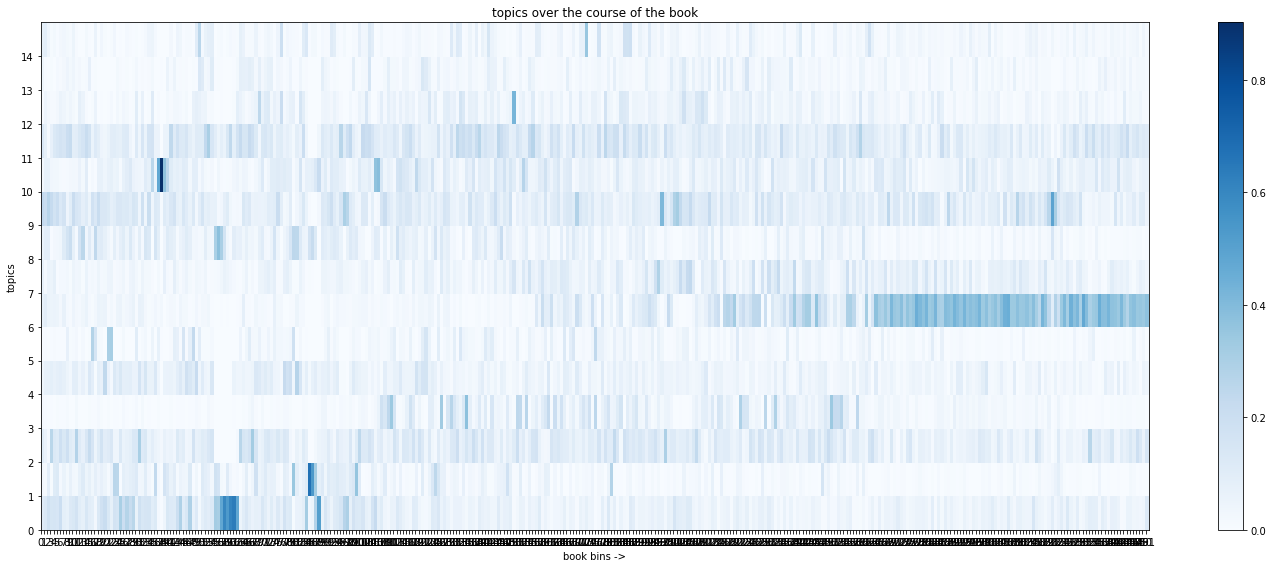

In [36]:
# increase the font size and add a title

K, N = binvals.shape  # N documents, K topics
topic_labels = ['Topic #{}'.format(k) for k in range(K)]

plt.figure(figsize=(20,8))

plt.pcolor(binvals.T, norm=None, cmap='Blues')

# the trailing semicolon ';' suppresses output
plt.yticks(np.arange(binvals.shape[1]));

plt.xticks(np.arange(binvals.shape[0]));

# add x and y labels and title
plt.xlabel('book bins ->')
plt.ylabel('topics')
plt.title('topics over the course of the book')

# add a legend
plt.colorbar(cmap='Blues')

# fix margins
plt.tight_layout() 

plt.show()

### Novel summarization:  (takes too long)

In [ ]:
# from __future__ import absolute_import
# from __future__ import division, print_function, unicode_literals
 
# from sumy.parsers.html import HtmlParser
# from sumy.parsers.plaintext import PlaintextParser
# from sumy.nlp.tokenizers import Tokenizer
# from sumy.summarizers.lsa import LsaSummarizer
# from sumy.nlp.stemmers import Stemmer
# from sumy.utils import get_stop_words
 
# from sumy.summarizers.luhn import LuhnSummarizer
# from sumy.summarizers.edmundson import EdmundsonSummarizer   #found this is the best as 
# # it is picking from beginning also while other skip
 
 
# LANGUAGE = "english"
# SENTENCES_COUNT = 10
 
 
# if __name__ == "__main__":

#     # for HTML sites:
#     #     url="https://en.wikipedia.org/wiki/Deep_learning"
#     #     parser = HtmlParser.from_url(url, Tokenizer(LANGUAGE))

#     # for plain text files:
# #     parser = PlaintextParser.from_file("file.txt", Tokenizer(LANGUAGE))

#     # for plain text variable:
#     parser = PlaintextParser(clean_books[novel_index], Tokenizer(LANGUAGE))
    
 
        
#     print ("--LsaSummarizer--")    
#     summarizer = LsaSummarizer()
#     summarizer = LsaSummarizer(Stemmer(LANGUAGE))
#     summarizer.stop_words = get_stop_words(LANGUAGE)
#     for sentence in summarizer(parser.document, SENTENCES_COUNT):
#         print(sentence)
         
#     print ("--LuhnSummarizer--")     
#     summarizer = LuhnSummarizer() 
#     summarizer = LsaSummarizer(Stemmer(LANGUAGE))
#     summarizer.stop_words = ("I", "am", "the", "you", "are", "me", "is", "than", "that", "this",)
#     for sentence in summarizer(parser.document, SENTENCES_COUNT):
#         print(sentence)
         
#     print ("--EdmundsonSummarizer--")     
#     summarizer = EdmundsonSummarizer() 
#     words = ("deep", "learning", "neural" )
#     summarizer.bonus_words = words
     
#     words = ("another", "and", "some", "next",)
#     summarizer.stigma_words = words
    
     
#     words = ("another", "and", "some", "next",)
#     summarizer.null_words = words
#     for sentence in summarizer(parser.document, SENTENCES_COUNT):
#         print(sentence)

### Make a dataframe with the cluster relationships so that we can use them in the future:

In [49]:
book_clusters.head()

,cluster,max_topic_cluster_words,max_topic_num,book
0,0,"[planet, ship, earth, space, room, martian, ma...",6,The Time Machine
1,0,"[planet, ship, earth, space, room, martian, ma...",6,The War of the Worlds
2,0,"[planet, ship, earth, space, room, martian, ma...",6,The First Men in the Moon
3,0,"[planet, ship, earth, space, room, martian, ma...",6,The Lani People
4,0,"[planet, ship, earth, space, room, martian, ma...",6,The Lord of Death and the Queen of Life


In [52]:
len(clean_book_sentences)

3524

In [64]:
clean_book_sentences_df = pd.DataFrame(clean_book_sentences)

In [66]:
clean_book_sentences_df.head()

,0,1,2,3,4,5,6,7,8,9,...,31916,31917,31918,31919,31920,31921,31922,31923,31924,31925
0,alice ' s adventure in wonderland lewis carrol...,0 chapter i .,down the rabbit - hole alice wa beginning to g...,so she wa considering in her own mind ( a well...,there wa nothing so very remarkable in that ; ...,oh dear !,i shall be late !',"( when she thought it over afterwards , it occ...","in another moment down went alice after it , n...",the rabbit - hole went straight on like a tunn...,...,None,None,None,None,None,None,None,None,None,None
1,through the looking - glass by lewis carroll t...,7 chapter i .,"looking - glass house one thing wa certain , t...",for the white kitten had been having it face w...,the way dinah washed her child ' s face wa thi...,but the black kitten had been finished with ea...,"oh , you wicked little thing !'","cried alice , catching up the kitten , and giv...","really , dinah ought to have taught you better...","you ought , dinah , you know you ought !'",...,None,None,None,None,None,None,None,None,None,None
2,the hunting of the snark lewis carroll the mil...,2 the hunting of the snark an agony in eight f...,"4 ) "" then the bowsprit got mixed with the rud...","in view of this painful possibility , i will n...","the bellman , who wa almost morbidly sensitive...",they knew it wa not of the slightest use to ap...,the helmsman used to stand by with tear in his...,"rule 42 of the code , "" no one shall speak to ...","so remonstrance wa impossible , and no steerin...",during these bewildering interval the ship usu...,...,None,None,None,None,None,None,None,None,None,None
3,the reader will find a complete text and html ...,gutenberg .,org / ebooks / 2701 ] moby dick by herman melv...,"he worked at odd job ( clerk , garmhand , teac...","he deserted his ship , lived among cannibal , ...",s .,"he successfully romanticized these adventure ,...","his popularity waned , and by the time he died...",_billy budd_ wa his last great novel .,"a his writing declined , melville sailed again...",...,None,None,None,None,None,None,None,None,None,None
4,the song of hiawatha henry w .,longfellow content introductory note introduct...,the peace - pipe ii .,the four wind iii .,hiawatha ' s childhood iv .,hiawatha and mudjekeewis v .,hiawatha ' s fasting vi .,hiawatha ' s friend vii .,hiawatha ' s sailing viii .,hiawatha ' s fishing ix .,...,None,None,None,None,None,None,None,None,None,None


In [67]:
book_clusters['sentences'] = clean_book_sentences_df
book_clusters.sort_values(by=['cluster']).head()

ValueError: Wrong number of items passed 31926, placement implies 1

In [68]:
doctopic_prob_df = pd.DataFrame()
for i in range(len(doctopic)):
    doctopic_prob_df[str(i)] = doctopic[i]

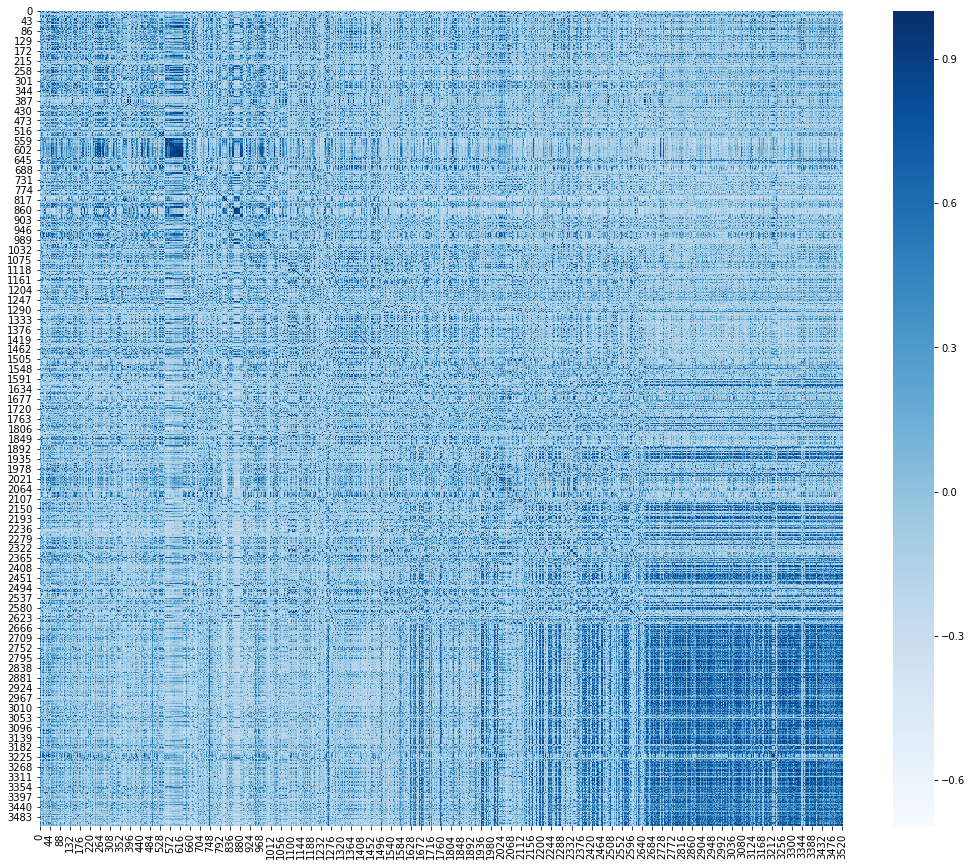

In [69]:
f, ax = plt.subplots(figsize=(18, 15))
corr = doctopic_prob_df.corr()
sns.heatmap(corr,cmap="Blues");

In [70]:
topic_df=pd.DataFrame()
for t in range(len(topic_words)):
#     print("Topic {}: {}".format(t, ' '.join(topic_words[t][:15])))
    topic_df['Topic %d' %t] = topic_words[t]
topic_df.T

,0,1,2,3,4,5,6,7,8,9,10
Topic 0,man,von,watson,wa,said,paper,holmes,ha,good,german,bork
Topic 1,wa,von,man,watson,holmes,good,said,paper,ha,german,bork
Topic 2,good,german,holmes,paper,ha,watson,wa,von,said,man,bork
Topic 3,watson,paper,ha,wa,von,said,man,holmes,good,german,bork
Topic 4,ha,man,watson,wa,von,said,paper,holmes,good,german,bork
Topic 5,paper,bork,man,watson,wa,von,said,holmes,ha,good,german
Topic 6,wa,good,watson,von,said,paper,man,holmes,ha,german,bork
Topic 7,watson,good,wa,von,said,paper,man,holmes,ha,german,bork
Topic 8,german,von,good,watson,wa,said,paper,man,holmes,ha,bork
Topic 9,said,good,watson,wa,von,paper,man,holmes,ha,german,bork


In [72]:
booknum = 0
norm_word_weights = [x/np.sum(word_weights[booknum]) for x in word_weights[booknum]]
# print(norm_word_weights)
# words_with_weights = zip(topic_words[booknum],norm_word_weights)
# list(words_with_weights)
words_with_weights = pd.DataFrame()
words_with_weights['words'] = topic_words[booknum]
words_with_weights['weights'] = norm_word_weights
words_with_weights.head()

NameError: name 'word_weights' is not defined

### reccomendation system

In [99]:
a = sentiment_array

In [100]:
b = doctopic

In [103]:
super_array = np.hstack((a, b))

In [111]:
recc_df = pd.DataFrame(super_array)

In [112]:
recc_df['titles']=titles

In [115]:
recc_df.set_index('titles')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
titles,,,,,,,,,,,,,,,,,,,,
Alice's Adventures in Wonderland,0.027813,0.021556,-0.007967,0.035141,0.058158,0.004910,0.000000,0.039282,0.035686,0.042345,0.000000,0.023558,0.021065,0.242214,0.054413,0.000000,0.295132,0.000000,0.000000,0.241396
Through the Looking-Glass,0.062069,0.067270,0.054077,0.066509,0.041067,0.000000,0.000000,0.023505,0.011763,0.082169,0.000000,0.018314,0.006266,0.294852,0.065805,0.000000,0.263696,0.000000,0.000000,0.233631
The Hunting of the Snark: An Agony in Eight Fits,0.053313,0.109819,0.014486,0.085181,0.002235,0.287034,0.018593,0.046128,0.028158,0.000000,0.000011,0.067522,0.269887,0.000000,0.112936,0.058592,0.091386,0.011137,0.000744,0.007873
Moby Dick,0.055155,0.083941,0.022135,0.066772,0.036421,0.009116,0.043378,0.011056,0.028141,0.000000,0.000000,0.000000,0.450912,0.006325,0.082286,0.031136,0.034382,0.000000,0.303267,0.000000
The Song of Hiawatha,0.087218,0.064291,0.181911,0.060598,0.075006,0.002783,0.133515,0.000000,0.008955,0.000000,0.000000,0.000000,0.000000,0.077477,0.673177,0.000000,0.104094,0.000000,0.000000,0.000000
The Time Machine,0.040365,0.048468,0.022071,0.032993,0.028157,0.207837,0.000000,0.020958,0.000000,0.000000,0.000000,0.284513,0.000000,0.000000,0.486691,0.000000,0.000000,0.000000,0.000000,0.000000
The War of the Worlds,0.032302,0.017406,0.000815,0.014257,0.011637,0.093202,0.000000,0.023204,0.001603,0.059467,0.000000,0.312485,0.000000,0.000000,0.493044,0.000000,0.016995,0.000000,0.000000,0.000000
The Legend of Sleepy Hollow,0.107982,0.105560,0.138361,0.029414,-0.006077,0.132090,0.032099,0.001981,0.034562,0.052726,0.000000,0.000000,0.000000,0.000000,0.430065,0.165367,0.151110,0.000000,0.000000,0.000000
The Strange Case of Dr. Jekyll and Mr. Hyde,0.046969,0.052752,-0.002624,0.021926,0.060896,0.244979,0.007667,0.472270,0.000000,0.151179,0.000000,0.055348,0.000000,0.000000,0.068556,0.000000,0.000000,0.000000,0.000000,0.000000


In [150]:
recc = recc_df.drop(['titles'], axis = 1)
recc = recc.values
recc_corr = np.matmul(recc, recc.T)
recc_corr_df = pd.DataFrame(data=recc_corr, index=titles, columns = titles)
recc_corr_df.head()

,Alice's Adventures in Wonderland,Through the Looking-Glass,The Hunting of the Snark: An Agony in Eight Fits,Moby Dick,The Song of Hiawatha,The Time Machine,The War of the Worlds,The Legend of Sleepy Hollow,The Strange Case of Dr. Jekyll and Mr. Hyde,Anne of Green Gables,...,Never Come Midnight,Beyond Bedlam,Someone to Watch Over Me,Wolfbane,Founding Father,The Rat Race,Slave Planet,D-99,Sentry Of The Sky,The Troublemakers
Alice's Adventures in Wonderland,0.218554,0.222077,0.053376,0.034770,0.095304,0.039817,0.045595,0.077048,0.037967,0.180075,...,0.063641,0.092843,0.064925,0.036315,0.064821,0.066495,0.057272,0.054315,0.101436,0.032048
Through the Looking-Glass,0.222077,0.240616,0.054949,0.035966,0.121383,0.048040,0.052746,0.095925,0.039329,0.174093,...,0.062898,0.082788,0.063769,0.041115,0.059917,0.065197,0.055755,0.052525,0.107883,0.034070
The Hunting of the Snark: An Agony in Eight Fits,0.053376,0.054949,0.210152,0.159154,0.108747,0.145467,0.111089,0.133490,0.113988,0.065045,...,0.155944,0.110039,0.158908,0.126547,0.113232,0.065436,0.106334,0.080935,0.089079,0.058327
Moby Dick,0.034770,0.035966,0.159154,0.323497,0.086543,0.052186,0.046943,0.068945,0.024071,0.031660,...,0.024173,0.040657,0.126267,0.031878,0.042807,0.030779,0.026472,0.035444,0.043086,0.016027
The Song of Hiawatha,0.095304,0.121383,0.108747,0.086543,0.542049,0.342970,0.339770,0.352903,0.060763,0.075915,...,0.038851,0.032342,0.038672,0.182872,0.064370,0.032946,0.057595,0.092177,0.056738,0.010847


In [154]:
recc_corr_df[]

KeyError: 0

In [160]:
book_name = "The Lost World"
list(recc_corr_df[book_name].sort_values(ascending=False)[1:6].index)

['The Young Voyageurs: Boy Hunters in the North',
 'The Red Dust',
 'The Mad Planet',
 'The Boy Hunters',
 'Beyond the Black River']

In [172]:
list(recc_corr_df[titles[1]].sort_values(ascending=False)[1:6].index)
#bookslist = list(reccomendation_df[novel_names[novel_index]].asort_values(ascending=False)[1:6].index)

['The Light Princess',
 'The Little Lame Prince',
 'The Surprising Adventures of the Magical Monarch of Mo and His People',
 'Plays of Gods and Men',
 'Fairy Tales from the Arabian Nights']

In [157]:
pickler = open("reccomendation.pkl","wb")
pickle.dump(recc_corr_df, pickler)
pickler.close()

### Source for some of this code:
- https://de.dariah.eu/
- https://de.dariah.eu/tatom/topic_model_python.html
- https://de.dariah.eu/tatom/topic_model_visualization.html#topic-model-visualization